# Exploring GTSAM  Package for Pose Optimization with Factor Graphs

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

# import gtsampy as gtsam
import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt
import numpy as np
from ipyvtklink.viewer import ViewInteractiveWidget
from vedo import  *

Autosaving every 180 seconds


In [2]:
import tensorflow as tf
from tensorflow import  sin, cos, tan

def R_tf(angs):
    """generates rotation matrix using euler angles
    angs = tf.constant(phi, theta, psi) (aka rot about (x,y,z))
            can be single set of angles or batch for multiple cells
    """

    if len(tf.shape(angs)) == 1:
        angs = angs[None,:]
    phi = angs[:,0]
    theta = angs[:,1]
    psi = angs[:,2]

    mat = tf.Variable([[cos(theta)*cos(psi), sin(psi)*cos(phi) + sin(phi)*sin(theta)*cos(psi), sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi)],
                       [-sin(psi)*cos(theta), cos(phi)*cos(psi) - sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(psi) + sin(theta)*sin(psi)*cos(phi)],
                       [sin(theta), -sin(phi)*cos(theta), cos(phi)*cos(theta)]
                        ])

    mat = tf.transpose(mat, [2, 0, 1])
    mat = tf.squeeze(mat)
    return mat

2023-02-05 08:34:31.089764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 08:34:31.238437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 08:34:31.238478: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 08:34:31.898848: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Establish Origin 

$ [x, y, z, \phi, \theta, \psi ] $

In [3]:
p = np.array([0,0,0,0,0,0], dtype = np.float64)
start = gtsam.Pose3(p)
print(start)

# newpt = gtsam.Pose3(np.array([1,1,1,0,0,0], dtype = np.float64))

R: [
	0, 3.16202e-322, 0;
	0, 4.00193e-322, 4.45812e-316;
	0, 4.45812e-316, 6.92638e-310
]
t: 2.47033e-323 2.47033e-323 1.70482e+262



# 3D Odometry with PixSet

In [235]:
#leddartech braided odometry via ICET ROS pkg ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# nframes = 100
# odometry_history = np.load("test_data/leddartech_pixset/T_vec_history_1and3and5.npy")[:nframes,:]
# pred_stds_history = np.load("test_data/leddartech_pixset/cov_vec_history_1and3and5.npy")[:nframes,:]
# #debug- only use non-releated indices
# # good_idx = np.array([0,1,3]) #,5,7])
# # odometry_history = odometry_history[good_idx]
# # print(odometry_history.dtype)
# ij = get_ij(odometry_history[:,6:].astype(np.int32)).numpy() #indices of each

#simplified data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# odometry_history = np.array([[1., 1, 0, 0, 0, 0., 0, 1],
#                              [1., 1, 0, 0, 0, 0., 1, 2],
#                              [1., 1, 0, 0, 0, 0., 2, 3], 
#                              [0., 1, 0, 0, 0, 0.0, 1, 4], #add conflicting measurement
#                              [1., 1, 0, 0, 0, 0., 3, 4] ]) 
# ij = odometry_history[:,-2:].astype(int)
# print(ij)

npts = 10
odometry_history = np.tile(np.array([0.0, 0.05, 0.002, 0.0, 0.0, 0.25]), (npts,1))
#add process noise
# odometry_history += np.random.randn(np.shape(odometry_history)[0], 
#                                     np.shape(odometry_history)[1])*np.array([0,0,0, 0.0,0.1,0.])  
pred_stds_history = np.tile(np.array([[0.001, 0.01, 0.001, 1e-6, 1e-5, 1e-4]]), (len(odometry_history),1))
ij = np.array([[0,1]])
for i in range(1,len(odometry_history)):
    ij = np.append(ij, np.array([[i, i+1]]), axis = 0)

#mess with last constraint (add loop closure)
# ij[-1,1] = 159 
# ij = np.append(np.array([[0,15]]), ij[:-1], axis = 0)

odometry_history = np.append(odometry_history, ij, axis= 1)   #match format output by ROS package
pred_stds_history = np.append(pred_stds_history, ij, axis= 1) #match format output by ROS package

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# print(ij)
# print(odometry_history)


In [236]:
from utils import get_ij

# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph() 

# Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise model (covariance matrix)
# priorMean = gtsam.Pose3(np.zeros([6,1], dtype = np.float64))  # prior at origin
priorRot = gtsam.Rot3(R_tf(np.array([0., 0., 0.3])))
priorMean = gtsam.Pose3(priorRot, np.array([0., 0., 1.0])) #prior at nonzero pose
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.001, 0.001, 0.001, 1e-5, 1e-5, 1e-5], dtype = np.float64))
# firstKey = initial.keys()[0] #TODO: what does this do???
graph.add(gtsam.PriorFactorPose3(0, priorMean, PRIOR_NOISE)) #constrain first point at priorMean

#loop through all constraints 
for i in range(len(ij)):
# for i in range(int(np.max(ij))):
# for i in range(1,int(np.max(ij)) + 1): #test
    #get constraint 
    raw_odom = odometry_history[i,:-2] #omit scan indices stored at end of line
    #convert to Point3 strucutre
    point = raw_odom[:3] 
    rot = gtsam.Rot3(R_tf(raw_odom[3:]))
    odometry_estimate = gtsam.Pose3(rot, point)
#     print("\n odometry estimate:\n", odometry_estimate)
    cov_estimate = gtsam.noiseModel.Diagonal.Sigmas(pred_stds_history[i,:-2])
#     cov_estimate = gtsam.noiseModel.Diagonal.Sigmas(pred_stds_history[i,:]) #dont need to omit scan indices for fake data
    first_idx = ij[i,0]
    second_idx = ij[i,1] 
#     print(first_idx, second_idx) #misses last element in ij!!!
    graph.add(gtsam.BetweenFactorPose3(first_idx, second_idx, odometry_estimate, cov_estimate))

# print(graph.size())
#set to zero initial conditions
initial = gtsam.Values()
# print(initial.keys())
# print("\n graph size:", graph.size())
# print(int(np.max(ij)))
# for j in range(graph.size()):
for j in range(int(np.max(ij))+1):
#     zero_rot = gtsam.Rot3(R_tf(np.array([0., 0., 0.])))
#     zero_pose3 = gtsam.Pose3(zero_rot, np.array([0., 0., 0.])) #does not work with zero initial conds??
#     initial.insert(j, zero_pose3)
    init_rot = gtsam.Rot3(R_tf(0.01*np.random.randn(3)))
    init_pose = gtsam.Pose3(init_rot, np.random.randn(3))
    initial.insert(j, init_pose)
    
# optimize using Levenberg-Marquardt optimization
# damped optimizer - seems to work much better here
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

# simple gauss newton - kinda unreliable for high DOF problems (especially with zero initial conditions)
# params = gtsam.GaussNewtonParams()
# params.setVerbosity("Termination")  # this will show info about stopping conds
# optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)

# dogleg
# params = gtsam.DoglegParams()
# optimizer = gtsam.DoglegOptimizer(graph, initial, params)

result = optimizer.optimize()
marginals = gtsam.Marginals(graph, result) #calculate covariance estimates for each pose

print("initial error = ", graph.error(initial))
print("final error = ", graph.error(result))
# print(initial.keys())
# print(graph.keys())

initial error =  4361575565643.8228
final error =  1.1881815467386221e-21


In [ ]:
#Plot results
plt1 = Plotter(N = 1, axes = 1, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []
disp = plot_results(disp, result, ij)
disp = plot_results(disp, result, ij, marginals) #draws covarince ellipsoids
plt1.show(disp, "Factor Graph Test")
# ViewInteractiveWidget(plt1.window) #need to comment out when working on laptop

In [230]:
def plot_results(disp, results, ij, marginals = None):
    
    #plot coordinates of point centers
    for i in range(result.size()): #loop through all elements in results
        p = result.atPose3(i).matrix()
        p_center = Points([[p[0,-1], p[1,-1],  p[2,-1]]], r = 5)
        disp.append(p_center)
        #add text labels
#         t = Text3D(i, p[:3,-1], s = 0.01, alpha = 0.3).followCamera() #need for deskop
        t = Text3D(i, p[:3,-1], s = 0.01, alpha = 0.3).follow_camera() #newer Vedo on Laptop?
        disp.append(t)

    #draw constraints using ij
    for c in range(len(ij)):
        #get coords of results i and j 
        pt1 = results.atPose3(ij[c,0]).translation()
        pt2 = results.atPose3(ij[c,1]).translation()
        L = Line(p0 = pt1, p1 = pt2, lw = 2)
        disp.append(L)
#         print("\n",ij[c])
#         print("pt1, pt2: \n", pt1, pt2)
    #TODO: color constraints by which ICET thread they came from (i.e. skip1, skip3, skip5, etc.)

    #draw covarince ellipsoids for each pose
    #TODO: transform to respective frame (CURRENTLY PLOTTING IN GLOBAL XYZ!!!)
    if marginals:
        for k in range(0, int(np.max(ij))):
            frame = result.atPose3(ij[k,0]).matrix()[None,:] #coordinate frame of pose i
#             frame = result.atPose3(ij[k,1]).matrix()[None,:] #draw ellispse at subsequent point j
            sigma = marginals.marginalCovariance(k)[None,:,:]
            sigma = tf.convert_to_tensor(sigma)
            disp = draw_ell(disp, frame, sigma)
#             print("--------- frame ", k, "---------------")
#             print(frame)
#             print(np.sqrt(np.diag(marginals.marginalCovariance(k))))
        
#         #plot last marginal covariance
#         frame = result.atPose3(ij[k,1]).matrix()[None,:] #draw ellispse at subsequent point j
#         sigma = marginals.marginalCovariance(k)[None,:,:]
#         sigma = tf.convert_to_tensor(sigma)
#         disp = draw_ell(disp, frame, sigma)
                                                 
    return(disp)
    

In [210]:
def draw_ell(disp, frame, sigma, pc = 1, alpha = 0.5):
    """draw distribution ellipses given mu and sigma tensors"""
    
    if pc == 1:
        color = [0.8, 0.3, 0.3]
    if pc ==2:
        color = [0.3, 0.3, 0.8]

    for i in range(tf.shape(sigma)[0]):

        mu = frame[:,:3,-1]
        
        eig = np.linalg.eig(sigma[i,:,:].numpy())
        eigenval = eig[0] #correspond to lengths of axis
        eigenvec = eig[1]
        
        #TODO:transform eigenvect to represent angles in frame of last odometry estimate
#         print("\n sigma: \n", tf.linalg.diag(sigma[0,:]))
#         print("\n eigenval: \n", eigenval)
#         print("\n eigenvec: \n", eigenvec)
#         print("\n frame[:,:3,:3] \n", frame[:,:3,:3])
#         eigenvec = eigenvec @ frame[:,:3,:3]
        
        # assmues decreasing size
#         a1 = eigenval[0]
#         a2 = eigenval[1]
#         a3 = eigenval[2]
        
        #not actually decreasing size when scale large enough
        a1 = tf.sort(eigenval).numpy()[-1]
        a2 = tf.sort(eigenval).numpy()[-2]
        a3 = tf.sort(eigenval).numpy()[-3]
        
#         print(a1, a2, a3)
#         print(tf.sort(eigenval).numpy())
#         a1 = 0.001
#         a2 = 0.001
#         a3 = 0.001

        if mu[i,0] != 0 and mu[i,1] != 0:
            ell = Ell(pos=(mu[i,0], mu[i,1], mu[i,2]), axis1 = 4*np.sqrt(abs(a1)), 
                axis2 = 4*np.sqrt(abs(a2)), axis3 = 4*np.sqrt(abs(a3)), 
                angs = (np.array([-R2Euler(eigenvec)[0], -R2Euler(eigenvec)[1], -R2Euler(eigenvec)[2] ])), c=color, alpha=alpha, res=12)
            disp.append(ell)
            
    return(disp)

In [240]:
class Ell(Mesh):
    """
    Build a 3D ellipsoid centered at position `pos`.

    |projectsphere|

    |pca| |pca.py|_
    """
    def __init__(self, pos=(0, 0, 0), axis1= 1, axis2 = 2, axis3 = 3, angs = np.array([0,0,0]),
                 c="cyan4", alpha=1, res=24):

        self.center = pos
        self.va_error = 0
        self.vb_error = 0
        self.vc_error = 0
        self.axis1 = axis1
        self.axis2 = axis2
        self.axis3 = axis3
        self.nr_of_points = 1 # used by pcaEllipsoid

#         if utils.isSequence(res): #desktop
        if utils.is_sequence(res): #laptop
            res_t, res_phi = res
        else:
            res_t, res_phi = 2*res, res

        elliSource = vtk.vtkSphereSource()
        elliSource.SetThetaResolution(res_t)
        elliSource.SetPhiResolution(res_phi)
        elliSource.Update()
        l1 = axis1
        l2 = axis2
        l3 = axis3
        self.va = l1
        self.vb = l2
        self.vc = l3
        axis1 = 1
        axis2 = 1
        axis3 = 1
        angle = angs[0] #np.arcsin(np.dot(axis1, axis2))
        theta = angs[1] #np.arccos(axis3[2])
        phi =  angs[2] #np.arctan2(axis3[1], axis3[0])

        t = vtk.vtkTransform()
        t.PostMultiply()
        t.Scale(l1, l2, l3)

        #needed theta and angle to be negative before messing with E_xz, E_yz...
        t.RotateZ(np.rad2deg(phi))
        t.RotateY(-np.rad2deg(theta)) #flipped sign here 5/19
        t.RotateX(-np.rad2deg(angle)) #flipped sign here 5/19
        
        tf = vtk.vtkTransformPolyDataFilter()
        tf.SetInputData(elliSource.GetOutput())
        tf.SetTransform(t)
        tf.Update()
        pd = tf.GetOutput()
        self.transformation = t

        Mesh.__init__(self, pd, c, alpha)
        self.phong()
        self.GetProperty().BackfaceCullingOn()
        self.SetPosition(pos)
        self.Length = -np.array(axis1) / 2 + pos
        self.top = np.array(axis1) / 2 + pos
        self.name = "Ell"

In [216]:
def R2Euler(mat):
    """determines euler angles from euler rotation matrix"""

    if len( tf.shape(mat) ) == 2:
        mat = mat[None, :, :]

    R_sum = np.sqrt(( mat[:,0,0]**2 + mat[:,0,1]**2 + mat[:,1,2]**2 + mat[:,2,2]**2 ) / 2)

    phi = np.arctan2(-mat[:,1,2],mat[:,2,2])
    theta = np.arctan2(mat[:,0,2], R_sum)
    psi = np.arctan2(-mat[:,0,1], mat[:,0,0])

    angs = np.array([phi, theta, psi])
    return angs

In [166]:
#DEBUG - [x, y, z, phi, theta, psi] -> Pose3
# t = np.array([1, 2, 3, 0.0 ,0.0 ,0.1])
# point = t[:3] 
# rot = gtsam.Rot3(R_tf(t[3:]))
# Pose = gtsam.Pose3(rot, point)
# print(Pose)

print(marginals)

Marginals: Graph:  
size: 11
factor 0: 
  A[0] = [
	100, 0, 0, 0, 0, 0;
	0, 100, 0, 0, 0, 0;
	0, 0, 100, 0, 0, 0;
	0, 0, 0, 1000, 0, 0;
	0, 0, 0, 0, 1000, 0;
	0, 0, 0, 0, 0, 1000
]
  b = [  1.52869e-19 -1.42898e-19 -5.55112e-15 -6.67119e-19 -8.00132e-19            0 ]
  No noise model
factor 1: 
  A[0] = [
	-96.8912, 24.7404, 1.54155e-16, -0, -0, -0;
	-24.7404, -96.8912, -5.92177e-17, -0, -0, -0;
	1.34453e-16, -9.57843e-17, -100, -0, -0, -0;
	-4.94808, -19.3782, 484.456, -9689.12, 2474.04, 1.54155e-14;
	19.3782, -4.94808, 123.702, -2474.04, -9689.12, -5.92177e-15;
	-50, -0, 6.7356e-17, 1.34453e-15, -9.57843e-16, -1000
]
  A[1] = [
	100, 0, 0, 0, 0, 0;
	0, 100, 0, 0, 0, 0;
	0, 0, 100, 0, 0, 0;
	0, 0, 0, 10000, 0, 0;
	0, 0, 0, 0, 10000, 0;
	0, 0, 0, 0, 0, 1000
]
  b = [  1.62387e-19 -9.22593e-20  1.38778e-15 -1.73472e-14           -0 -1.12757e-13 ]
  No noise model
factor 2: 
  A[1] = [
	-96.8912, 24.7404, 1.38989e-16, -0, -0, -0;
	-24.7404, -96.8912, -9.46451e-17, -0, -0, -0;
	1.11086e-

# 2D Odometry Example

<IPython.core.display.Javascript object>


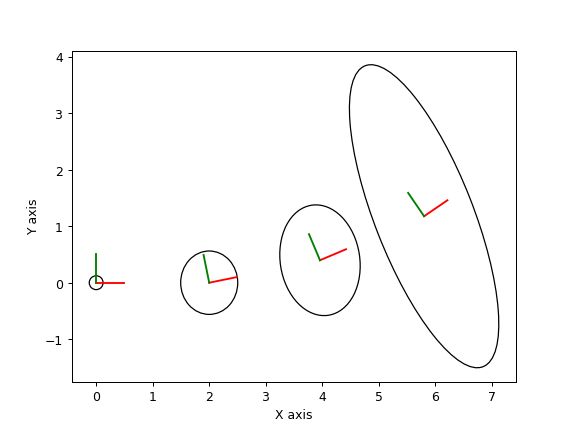

In [173]:
# Create noise models
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
ODOMETRY_NOISE2 = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.5])) #test
# PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.05, 0.05, 0.05])) #test


# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph()

# Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise model (covariance matrix)
priorMean = gtsam.Pose2(0.0, 0.0, 0.0)  # prior at origin
graph.add(gtsam.PriorFactorPose2(1, priorMean, PRIOR_NOISE))

# Add odometry factors
odometry = gtsam.Pose2(2.0, 0.0, 0.2)
# For simplicity, we will use the same noise model for each odometry factor
# Create odometry (Between) factors between consecutive poses
graph.add(gtsam.BetweenFactorPose2(1, 2, odometry, ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(2, 3, odometry, ODOMETRY_NOISE2))
graph.add(gtsam.BetweenFactorPose2(3, 4, odometry, ODOMETRY_NOISE2)) #test
# print("\nFactor Graph:\n{}".format(graph))

# Create the data structure to hold the initialEstimate estimate to the solution
# For illustrative purposes, these have been deliberately set to incorrect values
initial = gtsam.Values()
initial.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial.insert(3, gtsam.Pose2(4.1, 0.1, 0.1))
initial.insert(4, gtsam.Pose2(4.1, 0.1, 0.1))#test
# print("\nInitial Estimate:\n{}".format(initial))

#used for 2D
# optimize using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams() 
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

result = optimizer.optimize()
# print("\nFinal Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
# for i in range(1, 4):
#     print("X{} covariance:\n{}\n".format(i,
#                                          marginals.marginalCovariance(i)))

for i in range(1, 5):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5,
                          marginals.marginalCovariance(i))
plt.axis('equal')
plt.show()

In [172]:
#test plotting 2D odometry estimates
# a = gtsam.Pose2(0.5, 0.0, 0.2)

print(result.atPose2(2))


(2, -8.07766e-14, 0.2)



# Pose3 SLAM Example

g2o is a file format for representing human-readable graphs for optimization problems
https://github.com/uoip/g2opy

In [ ]:
g2oFile = "gtsampy/Data/pose3example.txt"
# g2oFile = gtsam.findExampleDataFile("pose3example.txt")
is3D = True
graph, initial  = gtsam.readG2o(g2oFile, is3D)
# print(initial)

priorModel = gtsam.noiseModel.Diagonal.Variances(
        np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))

firstKey = initial.keys()[0]
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), priorModel))

initialization = gtsam.InitializePose3.initialize(graph)
# print(initialization)